In this exercise we will decode orientation using data collected for the Cognitive Neuroscience module in 2017.  The subject performed a task that manipulated whether attention was placed towards the left or right visual field, or with no attentional focus (control condition).  The stimulus was two gabor patches left and right of fixation flickering at 5 Hz, with the following timing:

fixate: 500 ms
task cue: 500 ms
ISI: 1000 ms
stimulus: 4000 ms
change+resp: 1500 ms
var ITI: uniform distribution between 2500 and 9500 ms

Notes about the data files (from Dan):

*v1_tseries are the time series files, as voxel * volume matrices
*v1_r2 are the variance explained per voxel by the FIR model with three conditions for task=0/1/2
design is a long form matrix (rows are individual events, first column are volumes and second column trial type) indicating the volume at which the different trial types occurred, 0 = neutral task (press button when stimulus cross changes color), 1 = attend left side and detect the direction of rotation, 2 = attend right side and detect the direction of rotation 


##### Load data

First we load the data files.

using data from data
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2]
123 trials
163 voxels
3296 timepoints


(-0.5, 3295.5, 162.5, -0.5)

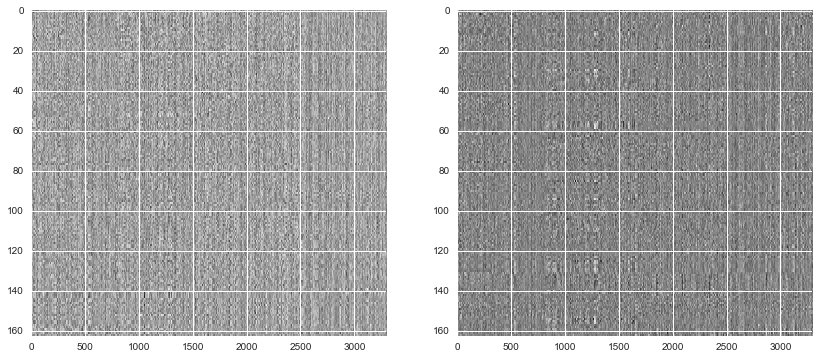

In [13]:
import os,json,glob,pickle
import numpy,pandas
import nibabel
import sklearn.multiclass
from sklearn.svm import SVC
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import scipy.stats,scipy.io
import random
import seaborn 
%matplotlib inline
import matplotlib.pyplot as plt


datadir='data'

print('using data from %s'%datadir)
lv1_ts=scipy.io.loadmat(os.path.join(datadir,'lv1_tseries.mat'))['lv1']
rv1_ts=scipy.io.loadmat(os.path.join(datadir,'rv1_tseries.mat'))['rv1']
# scale the data so that we don't need to bother with intercept in the model
lv1_ts=sklearn.preprocessing.scale(lv1_ts.T)
rv1_ts=sklearn.preprocessing.scale(rv1_ts.T)
tsdata={'leftV1':lv1_ts,'rightV1':rv1_ts}

desmtx=scipy.io.loadmat(os.path.join(datadir,'design.mat'))['design']
labels=desmtx[:,0]
print(labels)
ntrials=desmtx.shape[0]
ntp,nvox=lv1_ts.shape
print(ntrials,'trials')
print(nvox,'voxels')
print(ntp,'timepoints')
lv1_ts.shape

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(lv1_ts.T)
plt.axis('auto')
plt.subplot(1,2,2)
plt.imshow(rv1_ts.T)
plt.axis('auto')

(3296, 144)


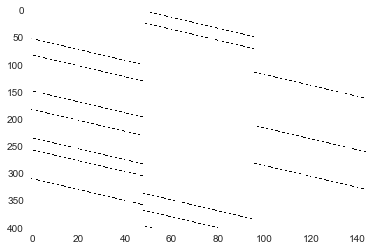

In [2]:
# Reproduce the deconvolution analysis using an FIR model
# the onset times are in volumes, so we just use tr=1
# use 20-second window

def make_fir_model(onsets,tslength,hrflength=48,tr=1):
    """
    generate an FIR model design matrix
    this only works for a single condition
    """
        
    X=numpy.zeros((tslength,int(hrflength/tr)))
    for i in range(hrflength):
        for o in onsets:
            try:
                X[o+i,i]=1
            except:
                pass
    return X

desmtx_df=pandas.DataFrame(desmtx,columns=['condition','onset'])
onsets={}
onsets['neutral']=desmtx_df.query('condition==0').onset.values
onsets['attendleft']=desmtx_df.query('condition==1').onset.values
onsets['attendright']=desmtx_df.query('condition==2').onset.values

left_fir=make_fir_model(onsets['attendleft'],ntp)
right_fir=make_fir_model(onsets['attendright'],ntp)
neutral_fir=make_fir_model(onsets['neutral'],ntp)
fir=numpy.hstack((left_fir,right_fir,neutral_fir))

# show the design matrix
plt.imshow(fir[:400,:])
plt.axis('auto')
print(fir.shape)

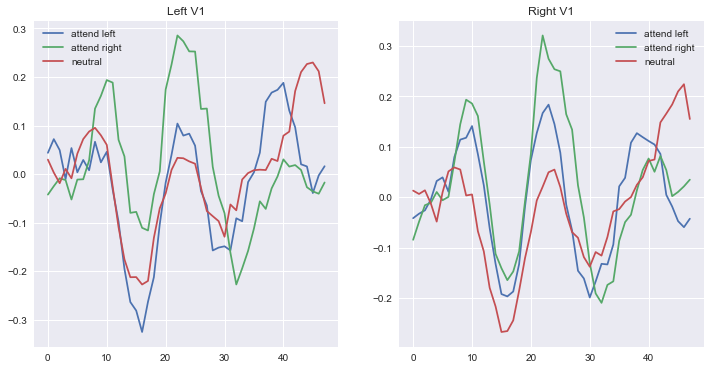

In [3]:
# estimate the model

beta_hat_left=numpy.linalg.inv(fir.T.dot(fir)).dot(fir.T).dot(lv1_ts)
beta_hat_right=numpy.linalg.inv(fir.T.dot(fir)).dot(fir.T).dot(rv1_ts)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(beta_hat_left[:48].mean(1))
plt.plot(beta_hat_left[48:96].mean(1))
plt.plot(beta_hat_left[96:144].mean(1))
plt.legend(['attend left','attend right','neutral'])
plt.title('Left V1')
plt.subplot(1,2,2)
plt.plot(beta_hat_right[:48].mean(1))
plt.plot(beta_hat_right[48:96].mean(1))
plt.plot(beta_hat_right[96:144].mean(1))
plt.legend(['attend left','attend right','neutral'])
plt.title('Right V1')

pred_left=fir.dot(beta_hat_left)

(3296,)

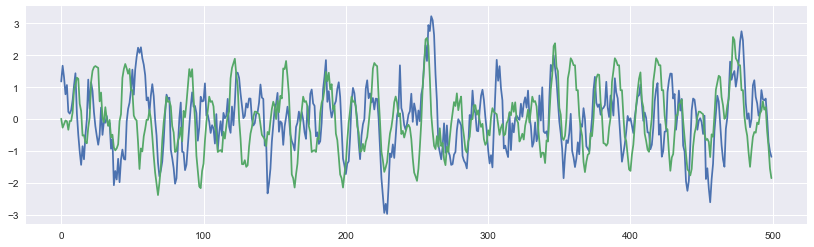

In [14]:
# check fit of the model over first 500 timepoints
plt.figure(figsize=(14,4))
plt.plot(sklearn.preprocessing.scale(lv1_ts.mean(1)[:500]))
#plt.plot(sklearn.preprocessing.scale(rv1_ts.mean(1)[:500]))
meanpred=sklearn.preprocessing.scale(pred_left.mean(1))

plt.plot(meanpred[:500])
pred_left.mean(1).shape

#### Classification analysis

Now let's fit a classifier using balanced 8-fold crossvalidation. For now we only include attention trials.  We will fit the classifier at each time point along the trial timecourse.  We use a nested crossvalidation loop to determine the classifier parameters for each dataset.

In [5]:
def run_classifier(data,labels, shuffle=False,nfolds=8,scale=True,
                  clf=None):
    """
    run classifier for a single dataset
    """
    features=data
    if scale:
        features=sklearn.preprocessing.scale(features)
    if shuffle:
        numpy.random.shuffle(labels)
    if not clf:
        clf=sklearn.svm.SVC(C=C)
    skf = sklearn.model_selection.StratifiedKFold(5,shuffle=True)
    pred=numpy.zeros(labels.shape[0])
    for train, test in skf.split(features,labels):
        clf.fit(features[train,:],labels[train])
        pred[test]=clf.predict(features[test,:])
    acc=sklearn.metrics.accuracy_score(labels, pred)
    return acc


def get_accuracy_timeseries(tsdata,labels_attend,onsets,shuffle=False,clf=None,window=40,
                           voxels=None):
    """
    iterate over timepoints
    """
    acc=numpy.zeros(window)
    for tp in range(window):  
        # pull out data for each trial/timepoint
        if voxels is None:
            data=numpy.zeros((len(labels_attend),tsdata['leftV1'].shape[1] + tsdata['rightV1'].shape[1]))
        else:
            data=numpy.zeros((len(labels_attend),tsdata[voxels+'V1'].shape[1]))
            
        ctr=0
        for cond in ['attendleft','attendright']:
            for ons in onsets[cond]:
                if voxels is None:
                    data[ctr,:]=numpy.hstack((tsdata['leftV1'][ons+tp,:],tsdata['rightV1'][ons+tp,:]))
                else:
                    data[ctr,:]=tsdata[voxels+'V1'][ons+tp,:]
                    
                ctr+=1
        acc[tp]=run_classifier(data,labels_attend,clf=clf,shuffle=shuffle)
    return acc

labels_attend=numpy.array([i for i in labels if i > 0])

#clf=sklearn.linear_model.LogisticRegressionCV(penalty='l1',solver='liblinear')
#clf=sklearn.svm.SVC(C=1)
tuned_parameters = [{'C': [0.0005,0.001,0.005,0.01,0.05, 0.1]}]
clf = sklearn.model_selection.GridSearchCV(sklearn.svm.LinearSVC(C=1), tuned_parameters, cv=5)

acc_all=get_accuracy_timeseries(tsdata,labels_attend,onsets,clf=clf)
acc_left=get_accuracy_timeseries(tsdata,labels_attend,onsets,voxels='left',clf=clf)
acc_right=get_accuracy_timeseries(tsdata,labels_attend,onsets,voxels='right',clf=clf)


#### Plot the results

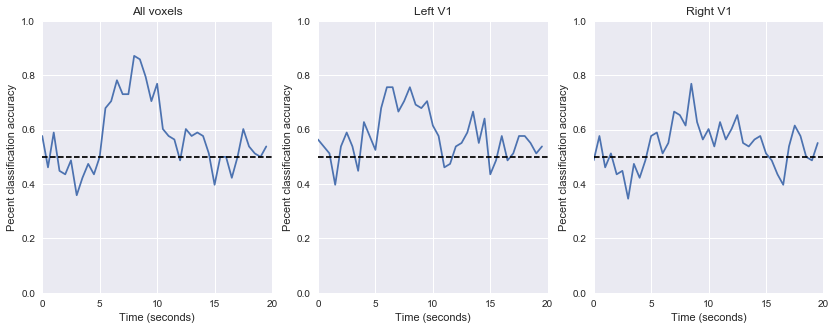

In [9]:
plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
plt.plot(numpy.arange(0,20,0.5),acc_all)
plt.axis([0,20,0,1])
plt.plot([0,20],[0.5,0.5],'k--')
plt.title('All voxels')
plt.xlabel('Time (seconds)')
plt.ylabel('Pecent classification accuracy')

plt.subplot(1,3,2)
plt.plot(numpy.arange(0,20,0.5),acc_left)
plt.axis([0,20,0,1])
plt.plot([0,20],[0.5,0.5],'k--')
plt.title('Left V1')
plt.xlabel('Time (seconds)')
plt.ylabel('Pecent classification accuracy')

plt.subplot(1,3,3)
plt.plot(numpy.arange(0,20,0.5),acc_right)
plt.axis([0,20,0,1])
plt.plot([0,20],[0.5,0.5],'k--')
plt.title('Right V1')
plt.xlabel('Time (seconds)')
plt.ylabel('Pecent classification accuracy')


Now let's run it with the labels shuffled 100 times to see how good these results are compared to chance.  This will take a little while to complete. For a real analysis one would want to do this many more times (up to ~5000) in order for the distribution of extreme values to stabilize.

In [7]:
# if the saved results already exist then just reload them, to save time
if os.path.exists('shuffled_accuracy.pkl'):
    print('loading existing shuffled data')
    acc_all_rand,acc_left_rand,acc_right_rand,clf=pickle.load(open('shuffled_accuracy.pkl','rb'))
else:
    acc_all_rand=numpy.zeros((100,40))
    acc_left_rand=numpy.zeros((100,40))
    acc_right_rand=numpy.zeros((100,40))

    for i in range(100):
        print(i)
        acc_all_rand[i,:]=get_accuracy_timeseries(tsdata,labels_attend,onsets,shuffle=True,clf=clf)
        acc_left_rand[i,:]=get_accuracy_timeseries(tsdata,labels_attend,onsets,voxels='left',shuffle=True,clf=clf)
        acc_right_rand[i,:]=get_accuracy_timeseries(tsdata,labels_attend,onsets,voxels='right',shuffle=True,clf=clf)
    pickle.dump((acc_all_rand,acc_left_rand,acc_right_rand,clf),open('shuffled_accuracy.pkl','wb'))


loading existing shuffled data


Now we plot those results alongside the true classification results, adding an asterisk at the timepoints where the observed accuracy is greater than the 99th percentile of the random accuracies.

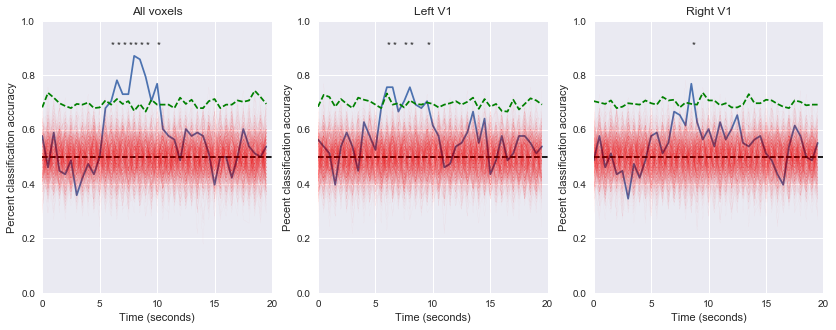

In [8]:
rand_percentile=(1 - 0.05/40)*100 # percent cutoff for randomization, bonferroni corrected
nrand=acc_all_rand.shape[0]

plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
plt.plot(numpy.arange(0,20,0.5),acc_all)
plt.axis([0,20,0,1])
plt.plot([0,20],[0.5,0.5],'k--')
plt.title('All voxels')
plt.xlabel('Time (seconds)')
plt.ylabel('Percent classification accuracy')
for i in range(nrand):
    plt.plot(numpy.arange(0,20,0.5),acc_all_rand[i,:],'r',linewidth=0.01)
cutoff=numpy.zeros(40)
for i in range(40):
    cutoff[i]=scipy.stats.scoreatpercentile(acc_all_rand[:,i],rand_percentile)
    if acc_all[i]>cutoff[i]:
        plt.text(i/2,0.9,'*')
plt.plot(numpy.arange(0,20,0.5),cutoff,'g--')

plt.subplot(1,3,2)
plt.plot(numpy.arange(0,20,0.5),acc_left)
plt.axis([0,20,0,1])
plt.plot([0,20],[0.5,0.5],'k--')
plt.title('Left V1')
plt.xlabel('Time (seconds)')
plt.ylabel('Pecent classification accuracy')
for i in range(nrand):
    plt.plot(numpy.arange(0,20,0.5),acc_left_rand[i,:],'r',linewidth=0.01)
cutoff=numpy.zeros(40)
for i in range(40):
    cutoff[i]=scipy.stats.scoreatpercentile(acc_left_rand[:,i],rand_percentile)
    if acc_left[i]>cutoff[i]:
        plt.text(i/2,0.9,'*')
plt.plot(numpy.arange(0,20,0.5),cutoff,'g--')


plt.subplot(1,3,3)
plt.plot(numpy.arange(0,20,0.5),acc_right)
plt.axis([0,20,0,1])
plt.plot([0,20],[0.5,0.5],'k--')
plt.title('Right V1')
plt.xlabel('Time (seconds)')
plt.ylabel('Pecent classification accuracy')
for i in range(nrand):
    plt.plot(numpy.arange(0,20,0.5),acc_right_rand[i,:],'r',linewidth=0.01)
cutoff=numpy.zeros(40)
for i in range(40):
    cutoff[i]=scipy.stats.scoreatpercentile(acc_right_rand[:,i],rand_percentile)
    if acc_right[i]>cutoff[i]:
        plt.text(i/2,0.9,'*')
plt.plot(numpy.arange(0,20,0.5),cutoff,'g--')
